#### **Final Project for "📸Introduction to Computer Vision"**
## **Классификация опухолей головного мозга с использованием МРТ-сканирования**

### 0. 📥 Imports

In [13]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import PIL
import pathlib
import PIL.Image
import warnings
from datetime import datetime
import random
from pathlib import Path
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

### 1. 📊 Problem Understanding and Dataset Selection:
#### **Определение проблемы:**
Целью этого проекта является классификация МРТ-сканов мозга по одной из следующих четырех категорий:
1. **Glioma - Глиома**
2. **Healthy - Здоровый**
3. **Meningioma - Менингиома**
4. **Pituitary - Гипофиз**

Эта задача классификации имеет решающее значение для ранней диагностики и планирования лечения опухолей головного мозга, что может спасти жизни.

### **Обзор набора данных**

Всего **7023 МРТ-сканов мозга**, разделенных на четыре класса.
1. **Glioma - Глиома**: 1,621 изображения {./dataset/glioma}
2. **Healthy - Здоровый**: 2,000 изображения {./dataset/healthy}
3. **Meningioma - Менингиома**: 1,645 изображения {./dataset/meningioma}
4. **Pituitary - Гипофиз**: 1,757 изображения {./dataset/pituitary}

Каждое изображение **изображение RGB размером 224x224 пикселей**, что обеспечивает достаточное разрешение для извлечения признаков с использованием методов глубокого обучения.

Я выбрала датасет с Kaggle, так как могу продемонстрировать свои знания и работать над задачей классификации типов опухолей, что, возможно, будет полезно как для меня, так и для других.

In [1]:
# аутентификация с токеном - расположенный на пути C:\Users\Qarlygash\.kaggle\kaggle.json
api = KaggleApi()
api.authenticate()

api.dataset_download_files("rm1000/brain-tumor-mri-scans", path="./dataset", unzip=True)

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
Датасет успешно скачан и распакован!


In [2]:
# проверила правильно ли кол-во изображений скачалось
dataset_path = "./dataset"
classes = ["glioma", "healthy", "meningioma", "pituitary"]

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    num_images = len(os.listdir(class_path))
    print(f"{cls.capitalize()}: {num_images} images")


Glioma: 1621 images
Healthy: 2000 images
Meningioma: 1645 images
Pituitary: 1757 images


### 2. 🔄 Data Preprocessing:
#### **Предпринятые действия:**
1. **Очистка данных:** Гарантировано отсутствие поврежденных или отсутствующих файлов.
2. **Нормализация:** Значения пикселей масштабированы до диапазона [0, 1].
3. **Augmentation:** Применено случайное переворачивание, регулировка яркости, изменение контрастности и обрезка для обучающих данных для улучшения обобщения модели.
4. **Разделение данных:**
- Обучающий набор: 80%
- Проверочный набор: 10%
- Тестовый набор: 10%

In [3]:
# Параметры
BATCH_SIZE = 5
IMAGE_SIZE = (224, 224)
dataset_path = "./dataset"
classes = ["glioma", "healthy", "meningioma", "pituitary"]

Здесь видно что изображение в формате RGB, поскольку размер тензора указан как (224, 224, 3). Третий размер 3 указывает на три цветовых канала: Red (красный), Green (зеленый) и Blue (синий), что соответствует формату RGB.

In [4]:
# Split data into train, validation, and test sets
def split_data():
    all_data = []
    for cls in classes:
        class_dir = os.path.join(dataset_path, cls)
        images = os.listdir(class_dir)
        random.shuffle(images)
        all_data.extend([(os.path.join(class_dir, img), cls) for img in images])
    random.shuffle(all_data)
    num_images = len(all_data)
    train_split = int(num_images * 0.8)
    val_split = int(num_images * 0.9)
    train_data = all_data[:train_split]
    val_data = all_data[train_split:val_split]
    test_data = all_data[val_split:]
    return train_data, val_data, test_data

train_data, val_data, test_data = split_data()

In [5]:
# Подготовка датасета
def prepare_dataset(data, is_train=False):
    file_paths, labels = zip(*data)
    labels = tf.keras.utils.to_categorical([classes.index(label) for label in labels], num_classes=len(classes))
    dataset = tf.data.Dataset.from_tensor_slices((list(file_paths), labels))

    def process_image(file_path, label):
        image = tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)
        image = tf.image.resize(image, IMAGE_SIZE) / 255.0
        if is_train:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)
            image = tf.image.random_brightness(image, max_delta=0.2)
            image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        return image, label

    dataset = dataset.map(process_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = prepare_dataset(train_data, is_train=True)
val_ds = prepare_dataset(val_data, is_train=False)
test_ds = prepare_dataset(test_data, is_train=False)

In [6]:
# Функция для визуализации изображений
def display_images_from_dataset(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    image_count = 0

    for image_batch, label_batch in dataset:
        for i in range(len(image_batch)):
            if image_count >= num_images:
                break
            plt.subplot(1, num_images, image_count + 1)
            image = image_batch[i].numpy()
            label = tf.argmax(label_batch[i]).numpy()
            plt.imshow((image * 255).astype("uint8"))
            plt.title(classes[label])
            plt.axis("off")
            image_count += 1
        if image_count >= num_images:
            break
    plt.show()

#### **Visualizations:**

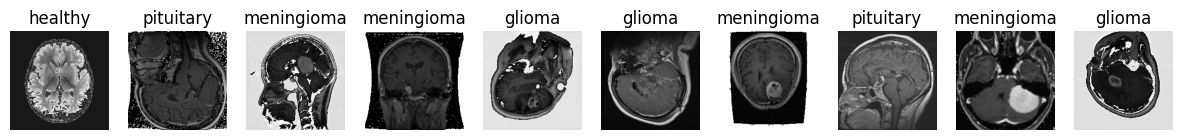

In [7]:
# Визуализация примеров изображений из тренировочного набора данных
display_images_from_dataset(train_ds, num_images=10)

In [8]:
# Преобразуем датасет в единый список изображений и меток
all_images = []
for image_batch, label_batch in train_ds:
    for i in range(len(image_batch)):
        image = image_batch[i].numpy()
        label_index = tf.argmax(label_batch[i]).numpy() 
        all_images.append((image, label_index))

# Случайно выбираем 5 изображений
random_samples = random.sample(all_images, 5)

for image, label_index in random_samples:
    print(image.shape, classes[label_index])

(224, 224, 3) healthy
(224, 224, 3) healthy
(224, 224, 3) glioma
(224, 224, 3) healthy
(224, 224, 3) healthy


### 3. 🧠 Model Selection and Implementation:

* CNN
* ResNet50

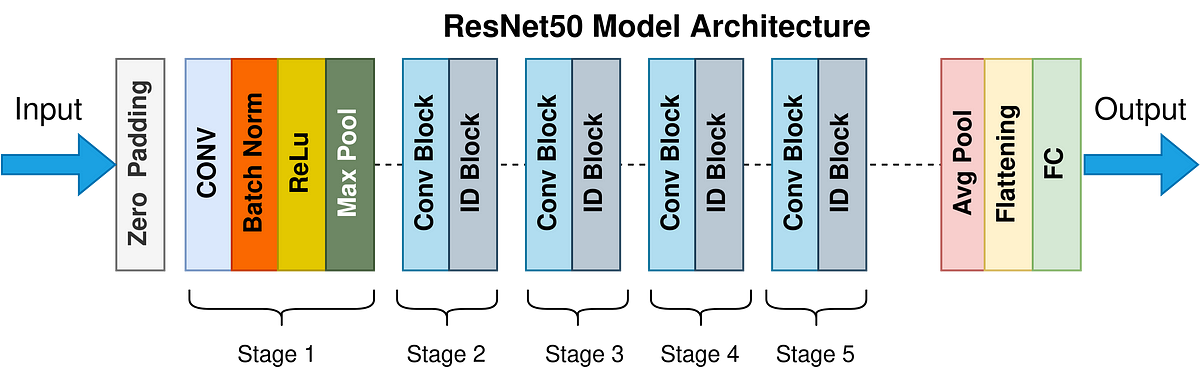

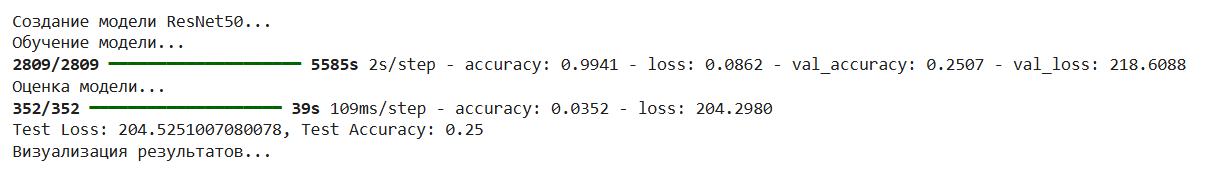

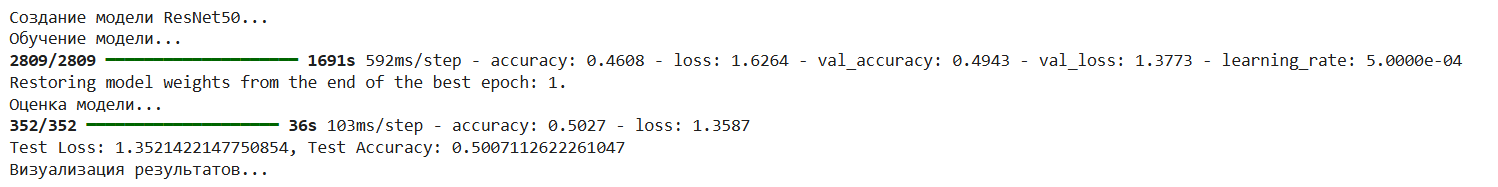

 Использованный алгоритм для модели ResNet50 основан на **Residual Learning** с добавлением остаточных блоков для решения проблемы деградации при глубоком обучении. Этот метод позволяет эффективно обучать очень глубокие нейронные сети.

In [15]:
# соңғы вариант осы
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense)

def conv_block(x, filters, kernel_size, strides=1, padding='same'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(x, filters):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=1)
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=1)
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def projection_block(x, filters, strides):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=strides)
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=1)
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters=filters * 4, kernel_size=(1, 1), strides=strides)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Initial conv layer
    x = conv_block(inputs, filters=64, kernel_size=(7, 7), strides=2, padding='same')
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Conv block 1
    x = projection_block(x, filters=64, strides=1)
    x = identity_block(x, filters=64)
    x = identity_block(x, filters=64)

    # Conv block 2
    x = projection_block(x, filters=128, strides=2)
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)

    # Conv block 3
    x = projection_block(x, filters=256, strides=2)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)

    # Conv block 4
    x = projection_block(x, filters=512, strides=2)
    x = identity_block(x, filters=512)
    x = identity_block(x, filters=512)

    # Global average pooling and dense layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = ResNet50(input_shape=(224, 224, 3), num_classes=len(classes))

### 4. 🏋️‍♂️ Model Training and Evaluation:

#### **Training:**

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=callbacks)


Epoch 1/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 1269s 1s/step - accuracy: 0.5065 - loss: 1.4519 - val_accuracy: 0.3433 - val_loss: 3.9153 - learning_rate: 5.0000e-04
Epoch 2/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 1410s 1s/step - accuracy: 0.6750 - loss: 0.7592 - val_accuracy: 0.6781 - val_loss: 1.1411 - learning_rate: 5.0000e-04
Epoch 3/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 1397s 1s/step - accuracy: 0.7245 - loss: 0.6345 - val_accuracy: 0.7892 - val_loss: 0.5636 - learning_rate: 5.0000e-04
Epoch 4/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 1313s 1s/step - accuracy: 0.7478 - loss: 0.5971 - val_accuracy: 0.7094 - val_loss: 1.0003 - learning_rate: 5.0000e-04
Epoch 5/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 1375s 1s/step - accuracy: 0.8010 - loss: 0.5050 - val_accuracy: 0.8490 - val_loss: 0.3913 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 5.


#### **Evaluation:**

In [17]:
def evaluate_model(model, test_ds):
    loss, accuracy = model.evaluate(test_ds)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

y_true, y_pred = [], []
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

print(classification_report(y_true, y_pred, target_names=classes))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

#### **Visualizations:**

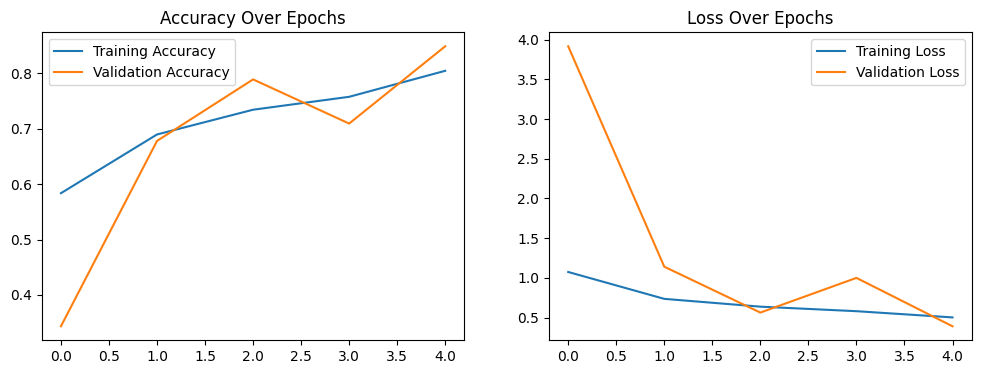

In [18]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

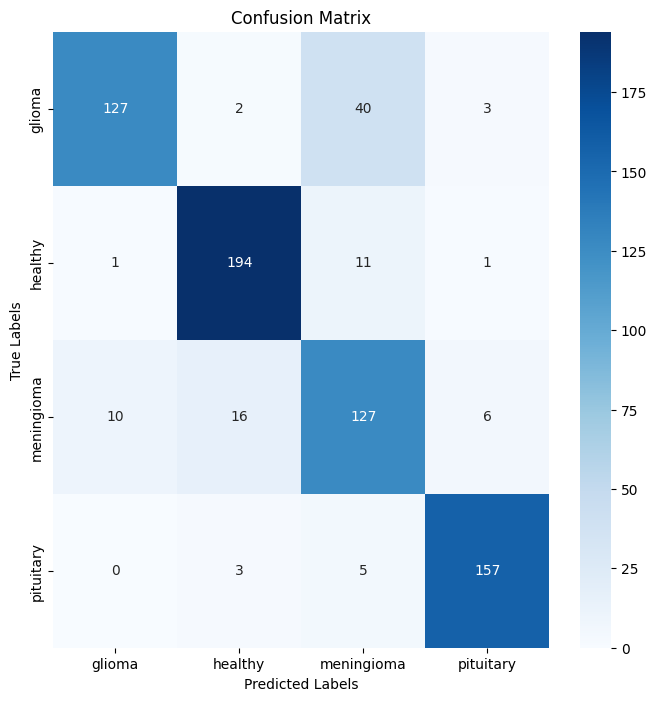

In [19]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, classes)

1шісі

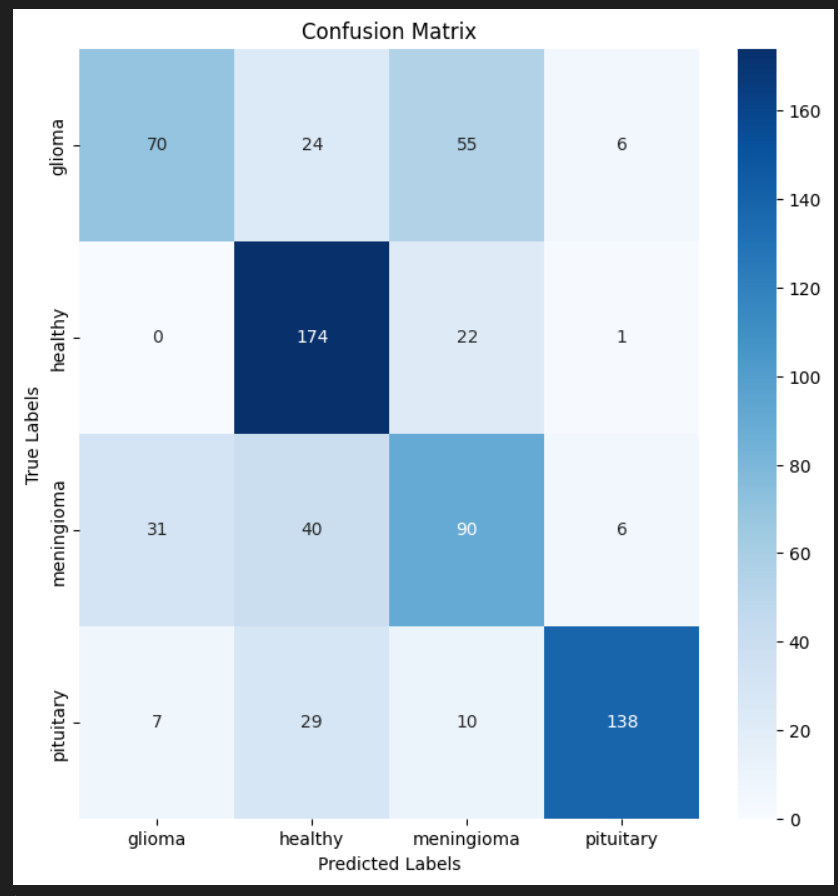

#### **Inference on a Single Image:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


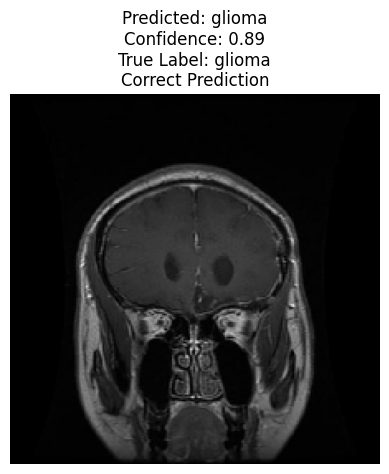

0

In [36]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def predict_single_image(model, image_path, true_label=None):
    image = load_img(image_path, target_size=IMAGE_SIZE)
    image_array = img_to_array(image) / 255.0
    image_array = tf.expand_dims(image_array, axis=0)

    predictions = model.predict(image_array)
    predicted_class = tf.argmax(predictions[0]).numpy()

    plt.imshow(image)
    title = f"Predicted: {classes[predicted_class]}\nConfidence: {predictions[0][predicted_class]:.2f}"
    if true_label is not None:
        true_class_name = classes[true_label]
        title += f"\nTrue Label: {true_class_name}"
        if true_label == predicted_class:
            title += "\nCorrect Prediction"
        else:
            title += "\nIncorrect Prediction"
    plt.title(title)
    plt.axis("off")
    plt.show()

    return predicted_class

predict_single_image(model, 'dataset/glioma/0011.jpg', true_label=0)

### 5. 💡 Result Analysis:

In [ ]:
results_df = pd.DataFrame(results)
import ace_tools as tools; tools.display_dataframe_to_user(name="ResNet50 Experiment Results", dataframe=results_df)

### 6. Источники

1. **Объяснение архитектуры ResNet**:  
   Татьяна Шарма, "Detailed explanation of residual network ResNet50 CNN model" — [Medium](https://medium.com/@sharma.tanish096/detailed-explanation-of-residual-network-resnet50-cnn-model-106e0ab9fa9e) 📘  

2. **Источник данных**:  
   Датасет "Brain Tumor MRI Scans" — [Kaggle](https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans/data) 📊
   


Трудности, которые возникли
1. Нормализация. Нормализация тоже в тензоре, например, между -1 и 1, а я сделала по-другому. Тогда, поскольку BatchNorm делится только на 255 и нуждается в сохранении своих статистических свойств, он привык к другой информации.
2. Переобучение
3. Увеличение.